In [3]:
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from writeit import *
import pickle
import time
from __future__ import division 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
fi = "../indata/Jamsh-new.inp"    
fc = "../indata/Jamsh-new.config" 
mtype=1
n1=PyNetwork(fi,fc,mtype)

In [5]:
n1.setbVal(0,0.42*np.ones(n1.M+1))             #set node 0 inflow as BC, v=2m/s
n1.setbVal(1,n1.Ds[1]*np.ones(n1.M+1))
#n1.setbVal(3,n1.Ds[2]*np.ones(n1.M+1)) 

In [6]:
dt = n1.T/n1.M                   
V0 = n1.getTotalVolume()                 
n1.runForwardProblem(dt) 
V1= n1.getTotalVolume()
print "The total run time is %f s, the total volume change is %f %f cubic meters" %(n1.solve_time, V1,V0)

The total run time is 43.647468 s, the total volume change is 28.574017 0.010799 cubic meters


   pipe | start node | end node
-----------------------------------
     0  |  0         | 2
     1  |  2         | 1
     2  |  2         | 3


   node | #incoming pipes
-------------------------
  0     |  1
  1     |  1
  2     |  3
  3     |  1


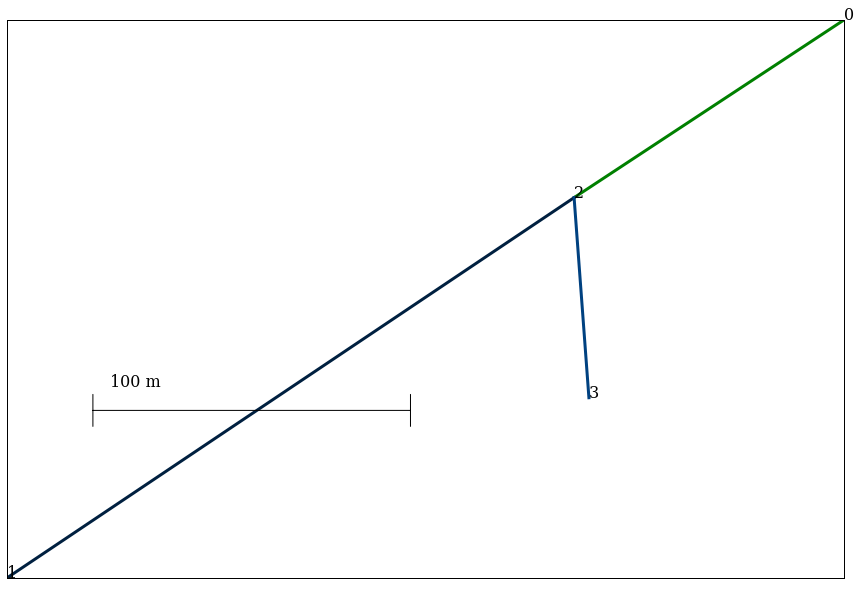

In [7]:
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np= shape(conns) [0]
plotNetworkLayout (xs, ys, conns, ls, Np)   
n1.showLayout() 

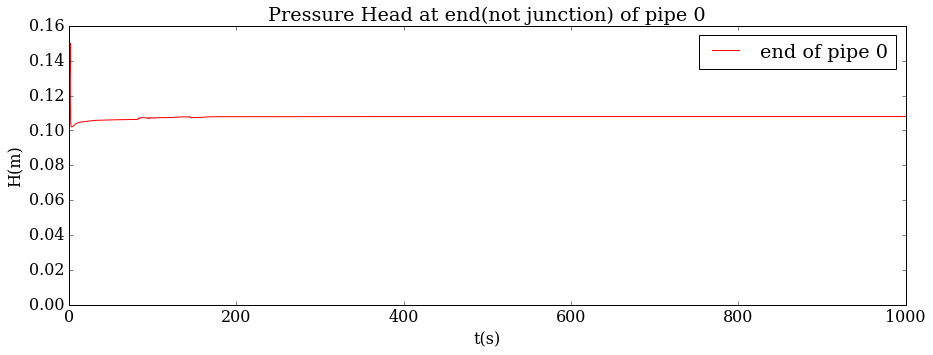

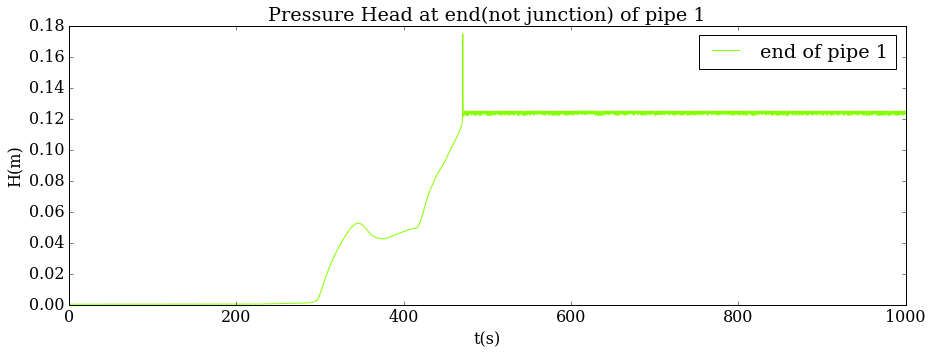

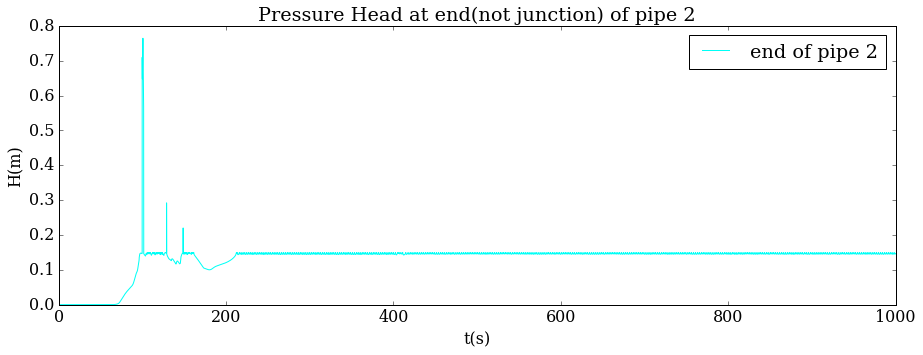

In [8]:
Np=n1.Nedges
from matplotlib import cm
import matplotlib.colors as colors
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('hsv') )
#fig = figure(figsize= (15,5))
t = linspace(0,n1.T,n1.M+1)
P1 = n1.pressureTimeSeries(0,0) 
#P1= n1.pressureTimeSeries(0,int((n1.Ns[0]+1)/2))
P2 = n1.pressureTimeSeries(1,n1.Ns[1]-1)
P3 = n1.pressureTimeSeries(2,n1.Ns[2]-1) 
P=[P1,P2,P3]
for i in range(0,3):
    plt.figure(figsize= (15,5))                  # so that every time it can create a new figure
    plt.plot(t,P[i],color =scalarMap.to_rgba(i),label = "end of pipe %d" %i)
    xlabel('t(s)')
    ylabel('H(m)')
    legend()
    title('Pressure Head at end(not junction) of pipe %d'%i)

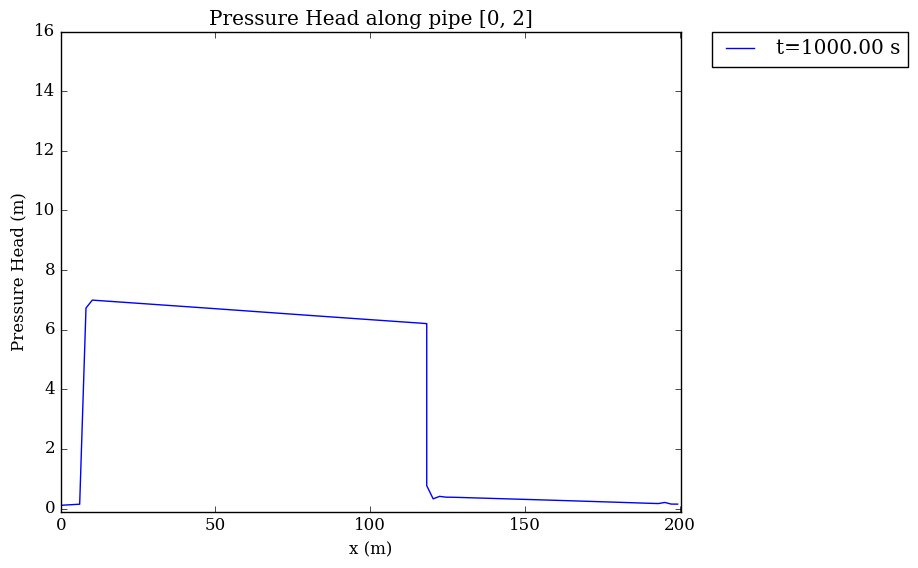

In [23]:
%matplotlib notebook
import pylab as pl
from IPython import display
plt.ion()
plt.show()


'''
Output: pressure changes with time for a certain nodes
        pressure along with a certain pipe for different time steps
        velocity in pipes

'''


# get p-x
sMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('prism') )  #or you can use Blues, BuGn
#fig = figure(figsize= (15,5))
pipe_interest=[0,2]

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]

# create H_interest which stores all the pressure head data corresponding to x

# H_interest_tfixed = [Hx1,Hx2,...,Hxj], pressure head at a certain time along all interesting pipes

# H_interested =n [H_interested1, H_interested2,..., H_interestedT], H_interested[i] =  fixed time step at i*Mi_draw
# dthen get ata from H_interested_tfixed

H_interest=[]
Mi_draw=500   # difne how many steps to skip
#M_total=int(n1.M/5)+1   # n1.M = 50000
M_total=n1.M+1
x_interest_combine = np.concatenate(x_interest,axis =0)
for m in range(0,M_total,Mi_draw) :  
    H_interest_tfixed=[]
    for j in pipe_interest:    
        Hx = n1.pressureSpaceSeries(j,m)  
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    #plt.figure(figsize= (15,5))    #plot on different figures
    figsize= (15,5)                 #plot on the same figure
    H_interest_combine = np.concatenate(H_interest[int(m/Mi_draw)],axis =0)
    pl.clf()
    pl.plot(x_interest_combine,H_interest_combine, lw = 1,label = 't=%.2f s'%(dt*m))
    '''
    for i in range(len(pipe_interest)):
        fig=figsize(15,5)
        color_number=m/M_total
        plot(x_interest[i],H_interest[int(m/Mi_draw)][i], lw = 1, color='%.2f'%color_number, label = 'pipe %d, t=%.2f s'%(pipe_interest[i],dt*m))
    '''
    # m is time step, and should divide m/Mi_draw to get what we need
    #plot(x,Hx, lw = 1, color = sMap.to_rgba(m), label = 't=%.2f'%(dt*m))
    xlabel('x (m)')        
    ylabel('Pressure Head (m)')
    xlim(0,x_interest[-1][-1]+1)
    Hmax=max(H_interest_combine)
    ylim(-0.1,16)
    #ylim(-0.1,1.1*Hmax)
    #print int(m/Mi_draw)      #for test
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title('Pressure Head along pipe %s'%str(pipe_interest)) 
    display.display(pl.gcf())
    display.clear_output(wait=True)
    #time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
    # optional:legend(loc = 'upper left')


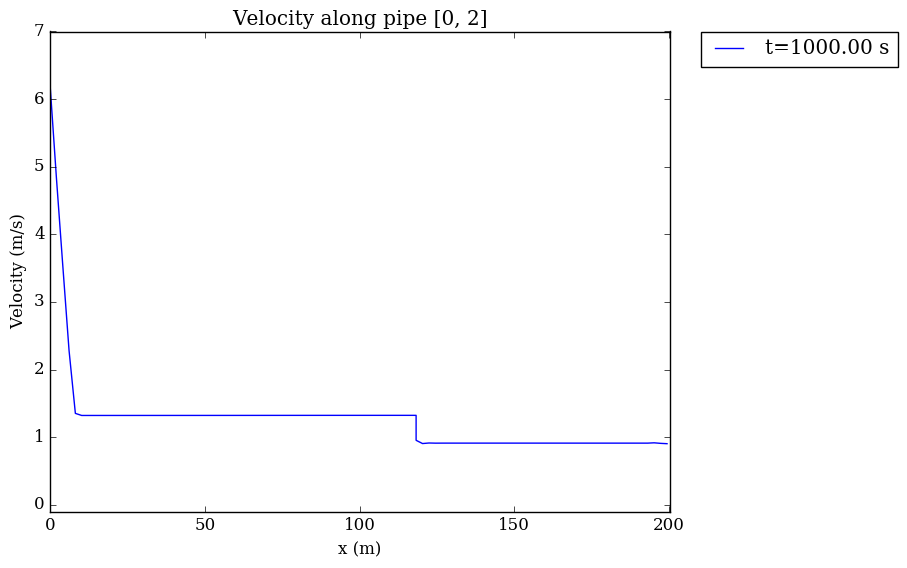

In [21]:
A_pipe=[]
for i in range(len(pipe_interest)):
    pipe_number=pipe_interest[i]
    A_pipe.append(n1.Ds[pipe_number]**2/4*pi)
    print 'pipe %d cross sectional area: A=%.4f m^2'%(pipe_number,A_pipe[i])
    
U_interest=[]
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)
#M_total=Mi_draw*1+1
for m in range(0,M_total,Mi_draw) :
    U_interest_tfixed=[] 
    for i in range(len(pipe_interest)):
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Utemp=[]
        for k in range(1,N+1):
            Ak=qh[idx_t(0,k,m,N)]
            AN=qh[idx_t(0,N,m,N)]
            Qk=qh[idx_t(1,k,m,N)]
            # when Q is actually very samll and its value is due to numerical oscillation, set it as 0
            if abs(Ak-AN)<0.01*A_pipe[i] and AN<0.01*A_pipe[i]:  
                Qk=0   
            vk = Qk/Ak                 
            Utemp.append(vk)
            #Utemp=[qh[idx_t(1,k,m,N)]/qh[idx_t(0,k,m,N)] for k in range(1,N+1)]
        U_interest_tfixed.append(Utemp)
    U_interest.append(U_interest_tfixed)
    U_interest_combine = np.concatenate(U_interest[int(m/Mi_draw)],axis =0)
    # plt.figure(figsize= (15,5))    #plot on different figures
    figsize= (10,4)                 #plot on the same figure
    pl.clf()
    pl.plot(x_interest_combine,U_interest_combine, lw = 1,label = 't=%.2f s'%(dt*m))
    #plt.show()
    #time.sleep(0.05)
    '''
    #plt.figure(figsize= (15,5))
    for i in range(len(pipe_interest)):
        figsize(15,5)
        plot(x_interest[i],U_interest[int(m/Mi_draw)][i], lw = 1,  label = 'pipe %d, t=%.2f s'%(pipe_interest[i],dt*m))
        # m is time step, and should divide m/Mi_draw to get what we need
        #plot(x,Hx, lw = 1, color = sMap.to_rgba(m), label = 't=%.2f'%(dt*m))
    '''
    xlabel('x (m)')        
    ylabel('Velocity (m/s)')
    xlim(0,x_interest[-1][-1]+1)
    Umax=1.1*max(U_interest_combine)
    ylim(-0.1,7)
    # ylim(-0.1,1.2*Umax)
    #print int(m/Mi_draw)      #for test
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title('Velocity along pipe %s'%str(pipe_interest))
    display.display(pl.gcf())
    display.clear_output(wait=True)
    #time.sleep(0.01)
    # print U_interest[5][1]   # first index is #*Mi timestep, second index is pipe # in pipe_interest list

# illustrate why v is not zero even when empty
# print n1.qhist(2)[idx_t(1,n1.Ns[2],10,n1.Ns[2])]   #Q
# print n1.qhist(2)[idx_t(0,n1.Ns[2]-20,100,n1.Ns[2])]   #A
# print n1.qhist(2)[idx_t(0,n1.Ns[2],100,n1.Ns[2])]

<IPython.core.display.Javascript object>


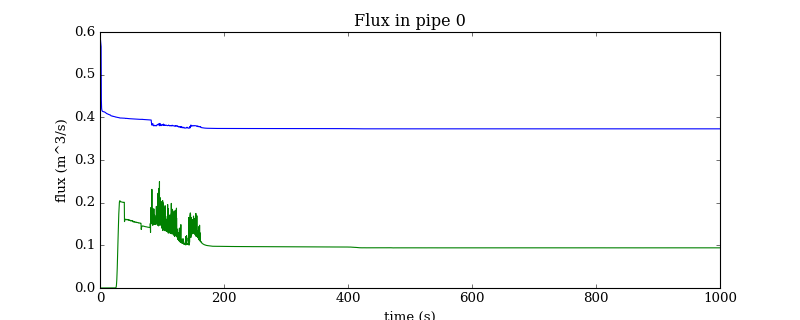

<IPython.core.display.Javascript object>


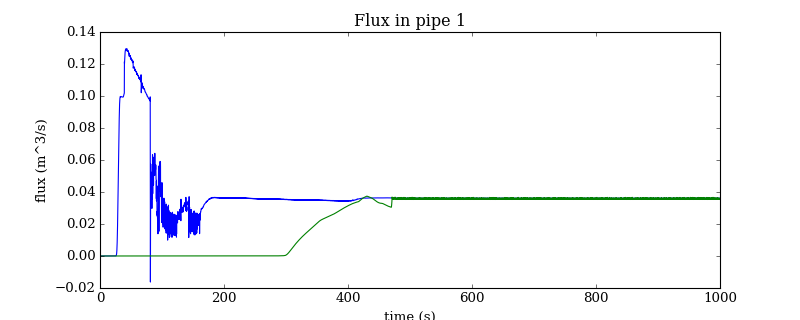

<IPython.core.display.Javascript object>


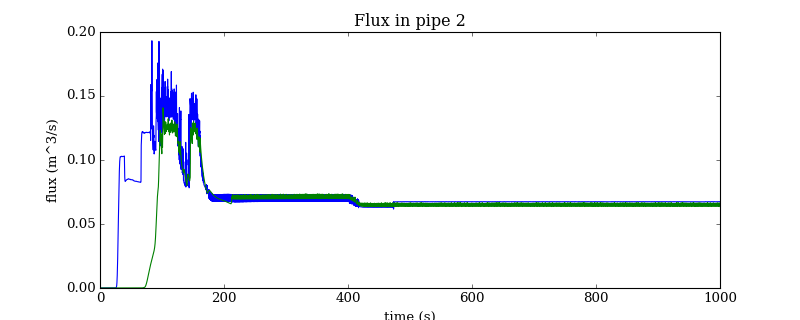

10000
10000
10000


<IPython.core.display.Javascript object>


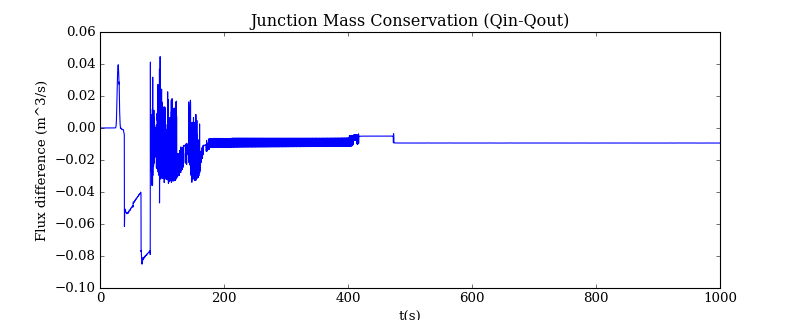

Pipe 0 during 1000 s have total flow: 376.207 m^3 (start node)
Pipe 0 during 1000 s have total flow: 99.369 m^3 (end node)
276.837991075
Pipe 1 during 1000 s have total flow: 38.192 m^3 (start node)
Pipe 1 during 1000 s have total flow: 23.139 m^3 (end node)
15.0532758012
Pipe 2 during 1000 s have total flow: 72.359 m^3 (start node)
Pipe 2 during 1000 s have total flow: 63.936 m^3 (end node)
8.42250670006


In [24]:
# Get Q of two ends of each pipe
Q = []
Mstep=10
pipe_interest=[0,1,2]   
'''Here I redefine the pipe_interest vector'''

for i in range(len(pipe_interest)):
    Q_pipefix = [] 
    Q_start=[]
    Q_end=[]
    for m in xrange(0,n1.M,Mstep) :
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Q_start.append(qh[idx_t(1,1,m,N)])   # Q1
        Q_end.append(qh[idx_t(1,N,m,N)])     # QN
    Q_pipefix.append(Q_start)
    Q_pipefix.append(Q_end)
    Q.append(Q_pipefix)
xt = np.linspace(0, n1.M*dt, n1.M/Mstep)
endorstart=['start','end']
for i in range(len(pipe_interest)):
    plt.figure(figsize= (10,4))                # same pipe on same figure
    for j in range(0,2):  
        #figsize = (15,5)                        # plot on same figure           
        #plt.figure(figsize= (15,5))             # plot on different figures
        plot(xt,Q[i][j], lw = 1,label = 'pipe %d, %s'%(pipe_interest[i],endorstart[j]))
        #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        xlabel('time (s)')
        ylabel('flux (m^3/s)')
        title('Flux in pipe %d'%pipe_interest[i])

print len(Q[0][1])
print len(Q[1][0])
print len(Q[2][0])
plt.figure(figsize= (10,4)) 
Q_dif_jun=[Q[0][1][k]-Q[1][0][k]-Q[2][0][k] for k in range(len(Q[0][1]))]
xlabel('t(s)')
ylabel('Flux difference (m^3/s)')
title('Junction Mass Conservation (Qin-Qout)')

plot(xt,Q_dif_jun)
            
# calculate inflow and outflow, i means pipe number, j means start or end, time means time in vector  
delta_t=Mstep*dt
Q_total=[]
for i in range(len(pipe_interest)):
    Q_total_pipefix=[]
    for j in range(0,2):
        Q_sum=0
        for time in range(len(Q[i][j])):
            Q_sum += Q[i][j][time]*delta_t
        Q_total_pipefix.append(Q_sum)
        print 'Pipe %d during %d s have total flow: %.3f m^3 (%s node)'%(pipe_interest[i],n1.T,Q_sum,endorstart[j])
    V_dif = Q_total_pipefix[0]- Q_total_pipefix[1]
    print V_dif
    Q_total.append(Q_total_pipefix)       

In [12]:
# Get A of two ends of each pipe
A = [] # all time, all pipes, all A values in grids
pipe_interest=[0,1,2]   
'''Here I redefine the pipe_interest vector'''

M_total=n1.M+1
Mi_draw=10000

for m in xrange(0,M_total,Mi_draw) :
    A_tfixed=[] # certain time, all pipes, all A values in grids
    for i in xrange(len(pipe_interest)):
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Atemp=[]  #certain time, certain pipe, all A values in grids
        for k in xrange(1,N+1):
            Ak=qh[idx_t(0,k,m,N)]      
            Atemp.append(Ak)
        A_tfixed.append(Atemp)     
    A.append(A_tfixed)
        
#calculate total volumn, i means time, j means pipe number, distance means value of grids  
V_total=[]
for i in xrange(0,M_total,Mi_draw):
    V_total_tfix=[]
    for j in xrange(len(pipe_interest)):
        V_sum=0
        pipe_number=pipe_interest[j]
        delta_x=n1.Ls[pipe_number]/n1.Ns[pipe_number]
        for distance in xrange(len(A[int(i/Mi_draw)][j])):
            V_sum += A[int(i/Mi_draw)][j][distance]*delta_x
        V_total_tfix.append(V_sum)
        print 'Pipe %d during %d s have total flow: %.3f m^3 '%(pipe_number,i*dt,V_sum)
    print 'The total volumn at t=%d s are                      %.3f m^3'%(i*dt,sum(V_total_tfix))
    V_total.append(Q_total_pipefix)
print n1.getTotalVolume()

Pipe 0 during 0 s have total flow: 0.003 m^3 
Pipe 1 during 0 s have total flow: 0.006 m^3 
Pipe 2 during 0 s have total flow: 0.002 m^3 
The total volumn at t=0 s are                      0.011 m^3
Pipe 0 during 100 s have total flow: 8.365 m^3 
Pipe 1 during 100 s have total flow: 6.176 m^3 
Pipe 2 during 100 s have total flow: 5.735 m^3 
The total volumn at t=100 s are                      20.276 m^3
Pipe 0 during 200 s have total flow: 8.381 m^3 
Pipe 1 during 200 s have total flow: 9.187 m^3 
Pipe 2 during 200 s have total flow: 5.685 m^3 
The total volumn at t=200 s are                      23.253 m^3
Pipe 0 during 300 s have total flow: 8.381 m^3 
Pipe 1 during 300 s have total flow: 12.745 m^3 
Pipe 2 during 300 s have total flow: 5.732 m^3 
The total volumn at t=300 s are                      26.858 m^3
Pipe 0 during 400 s have total flow: 8.381 m^3 
Pipe 1 during 400 s have total flow: 14.344 m^3 
Pipe 2 during 400 s have total flow: 5.732 m^3 
The total volumn at t=400 s are